# Compute and use FD gated likelihood

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import os, datetime
from tqdm import tqdm
from numpy.fft import rfft, irfft

from lisatools.diagnostic import *
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens, LISASens
from lisatools.utils.constants import *
from lisatools.detector import ESAOrbits, EqualArmlengthOrbits
from lisatools.datacontainer import DataResidualArray 
from lisatools.analysiscontainer import AnalysisContainer

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral
from few.utils.utility import get_p_at_t
from few.utils.fdutils import *
traj_module = EMRIInspiral(func="KerrEccEqFlux")

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from eryn.backends import HDFBackend

from fastlisaresponse import pyResponseTDI, ResponseWrapper

try:
    import cupy as cp
except Exception:
    cp = None

In [2]:
# gpu
use_gpu = False

In [3]:
# metric
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
traj = "KerrEccEqFlux"

In [4]:
# Observation parameters
#Tobs = 1  # [years]
#dt = 50.0  # [s]

Tobs = 0.006 # almost 2 days [yrs]
dt = 10.0  # [s]
eps = 1e-5  # mode content

emri_waveform_kwargs = dict(T=Tobs, dt=dt, eps=eps)

In [5]:
# Waveform parameters
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
#p0 = 8.2  # initial semi-latus rectum
p0 = 5.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

qK = np.pi / 6  # polar spin angle (theta)
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 6  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle

Phi_phi0 = np.pi / 3
Phi_theta0 = np.pi / 6
Phi_r0 = np.pi / 3



emri_waveform_args = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

In [6]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

#tdi_chan="AET"
#tdi_labels=["A", "E", "T"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"
#tdi_gen="2nd generation"


response_kwargs = dict(
        Tobs=Tobs,
        dt=dt,
        #t0 = 10000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=EqualArmlengthOrbits(),
    )

Generate TD data with detector response --> chans

In [7]:
# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=False,
                                **response_kwargs)




def fastlisaresponse(*params, emri_waveform_kwargs=None):
    return lisa_response(*params, **(emri_waveform_kwargs or {}))

#### Generate TD waveform

In [8]:
# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 10.66 s


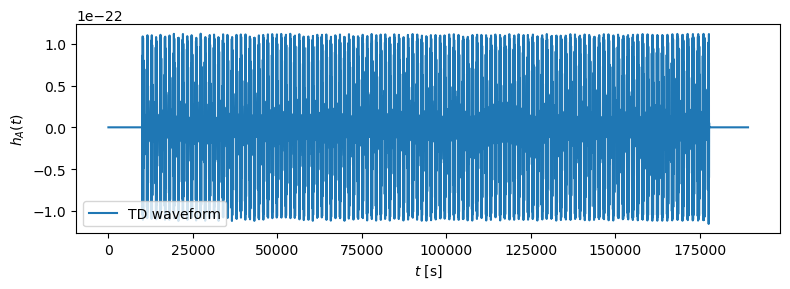

In [9]:
# Visualise the signal
time_array = np.arange(0,len(chans[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans[0], label='TD waveform')
plt.ylabel(r'$h_{A}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(1.7e5,1.9e5)
plt.legend()
plt.tight_layout()

plt.show()

#### Transform in FD and cut the data above minimum frequency

In [10]:
# Compute f_min
r_apo = p0 * M * MTSUN_SI / (1 - e0)  # meters
r_per = p0 * M * MTSUN_SI / (1 + e0)  # meters
r0 = (r_apo+r_per)/2

f_orb_0 = np.sqrt(M * MTSUN_SI / r0**3) / (2 * np.pi)  # rad/s

f_min = 2 * f_orb_0

In [11]:
N = len(chans[0])
freqs = np.fft.rfftfreq(N, d=dt)       
complete_data = np.fft.rfft(chans, axis=-1) * dt  # FD

freq_threshold = f_min
mask = freqs > freq_threshold

data_filtered = complete_data[:,mask] # Cut above min freq
freq_filtered = freqs[mask]

#### Define w and W (gated function)

Choose positions of gaps: at 20%, 40%... of signal

In [12]:
N_d = 2*int(60*60/dt)   # Length gap: 2 hrs
#N_d = 2*int(60*60*24/dt)  # Length gap: 2 day

N_tot = len(chans[0])   # Tot lenght of signal

u = np.array([0.20, 0.40, 0.60, 0.80])  # position of gaps (after 20%, 40%... of signal)
# u = np.array([0.20, 0.45, 0.70, 0.95]) 

idx = np.floor(u * (N_tot - N_d) - 1).astype(int) # obtain the indeces of such positions

Create w: 0 where gaps, 1 where data

In [13]:
w = np.ones(N_tot, dtype=int)  
for i in idx: w[i:i+N_d] = 0     

Dataset with gaps obtained by multiplying the waveform by w (which sets the gap portions to zero)

In [14]:
chans_gap = chans * w

W diagonal matrix obtained by putting to zero the entries that correspond to gaps (= w as its diagonal)

In [15]:
W = np.diag(w)

Visualise signal with gaps

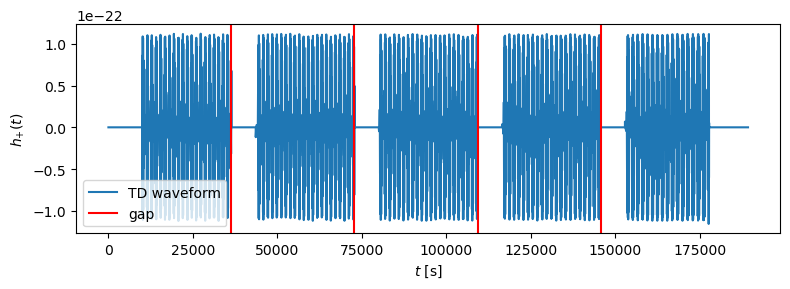

In [16]:
time_array = np.arange(0,len(chans_gap[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans_gap[0], label='TD waveform')
plt.axvline(idx[0]*dt, color='r', label='gap')
plt.axvline(idx[1]*dt, color='r')
plt.axvline(idx[2]*dt, color='r')
plt.axvline(idx[3]*dt, color='r')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(2.3e7,2.7e7)
plt.legend()
plt.tight_layout()

plt.show()

### Check FD plot

In [17]:
fft_gated = np.fft.rfft(chans_gap[0]) * dt
freq_gated = np.fft.rfftfreq(len(chans_gap[0]), dt)

positive_frequency_mask_gated = (freq_gated > 0.0)

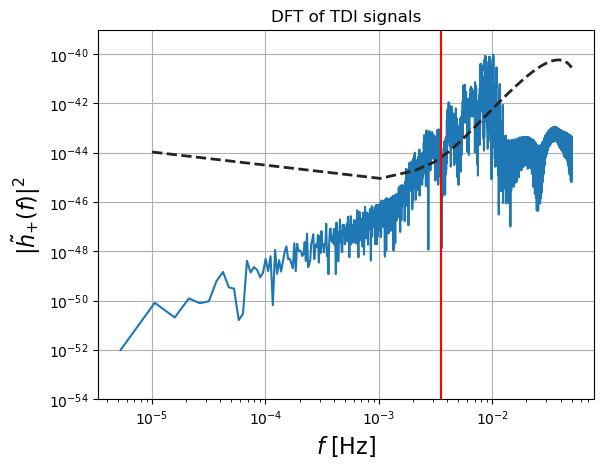

In [18]:
extr_freq_a = 1e-5
extr_freq_b = 5e-2
freq_grid = np.linspace(extr_freq_a, extr_freq_b)

plt.loglog(freq_gated[positive_frequency_mask_gated],
                 4 * freq_gated[positive_frequency_mask_gated]**2 * np.abs(fft_gated[positive_frequency_mask_gated])**2)
plt.loglog(freq_grid, get_sensitivity(freq_grid, sens_fn='A1TDISens', return_type='PSD')*freq_grid,
             color='#272323', linestyle='--', linewidth=2,   label='A/E ch. sens')
plt.axvline(f_min, c='r')
plt.ylabel(r'$| \tilde{h}_{+} (f)|^2$',fontsize=16)
plt.grid()
plt.xlabel(r'$f$ [Hz]',fontsize=16)
plt.ylim([1e-54, 1e-39])
plt.title('DFT of TDI signals')
plt.show()

# FD likelihood 

### Compute pseudoinverse of gated covariance in FD

I'm doing everything for one channel (A). If it works, then I'll add also the second channel in the computation of the likelihood.

First, I compute Sigma tilde.

In [19]:
N = len(W)
df = 1.0 / (N * dt)

# Compute positive psd using lisatools 'get_sensitivity' (for channel A for now)
freqs = np.fft.rfftfreq(N, d=dt)

freq_threshold = f_min
mask = freqs > freq_threshold

freq_filt = freqs[mask]

In [20]:
Sn = get_sensitivity(freq_filt, sens_fn="A1TDISens")
Sigma_tilde_diag = Sn / (2 * df)  # Nota: divido per df, non moltiplico!
Sigma_tilde_filt = np.diag(Sigma_tilde_diag)
print(Sigma_tilde_filt)

[[1.69948036e-37 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.70519975e-37 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71094465e-37 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.38003136e-35
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  5.37536515e-35 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.37069978e-35]]


Then, compute W_tilde

In [21]:
from scipy.linalg import circulant
# Invece di fare FFT di W (matrice), fai FFT di w (vettore)
w_tilde = np.fft.rfft(w) * dt  # FFT del vettore w

W_tilde = circulant(w_tilde)

# Filtra
W_tilde_filt = W_tilde[np.ix_(mask, mask)]

print(f"W_tilde_filt shape: {W_tilde_filt.shape}")
print(f"Sigma_tilde_filt shape: {Sigma_tilde_filt.shape}")

W_tilde_filt shape: (8797, 8797)
Sigma_tilde_filt shape: (8797, 8797)


In [22]:
print(freq_filt.shape)
print(W_tilde_filt.shape)
print(Sigma_tilde_filt.shape)

(8797,)
(8797, 8797)
(8797, 8797)


In [23]:
Sigma_tilde_gated = W_tilde_filt @ Sigma_tilde_filt @ W_tilde_filt.conj().T

Now I compute the pseudoinverse (and save it in a file, because the computation is quite long).

In [24]:
pinv_computation = False

pinv_filename = "pinv_Sigma_tilde_gated.npy"

if pinv_computation:
    # Compute pseudoinverse
    start = time.time()
    pinv_Sigma_tilde_gated = np.linalg.pinv(Sigma_tilde_gated)
    print(f"Pseudoinverse computation took {time.time()-start:.2f} s")
    
    # Save result
    np.save(pinv_filename, pinv_Sigma_tilde_gated)
    print(f"Pseudoinverse saved to {pinv_filename}")
else:
    # Load pseudoinverse from file
    print(f"Loading pseudoinverse from {pinv_filename}")
    pinv_Sigma_tilde_gated = np.load(pinv_filename)
    print(f"Pseudoinverse loaded successfully")

Loading pseudoinverse from pinv_Sigma_tilde_gated.npy
Pseudoinverse loaded successfully


I see that pinv_Sigma_filt is complex. But is the imaginary part different from zero?

In [25]:
max_imag = np.max(np.abs(np.imag(pinv_Sigma_tilde_gated)))
print("Max imaginary part:", max_imag)

Max imaginary part: 4.78306469536053e+23


Yes it is. Is this a problem?

### Define likelihood function in FD

Define the function for h (template), which does everything I did to generate and cut my FD dataset (without gaps).

In [26]:
def signal_gen(*emri_waveform_args):
    chans = fastlisaresponse(*emri_waveform_args, emri_waveform_kwargs=emri_waveform_kwargs)

    nchan, N = np.shape(chans)
    freqs = np.fft.rfftfreq(N, d=dt)       
    complete_data = np.fft.rfft(chans, axis=-1) * dt 

    freq_threshold = f_min
    mask = freqs > freq_threshold

    data_filtered = complete_data[:,mask]
    freq_filtered = freqs[mask]
    return data_filtered

Define function to compute the residuals, as presented in Eq.52 of Burke+(2025) paper.

I pass my TD dataset d (without gaps), the gated matrix W and the FD template h.

First I apply W to d, obtaining the gapped TD dataset. Then I transform it in FD and CUT IT. Finally I subtract the template h.

In [27]:
def residual_computation(d, W, h):
    gated_data = W @ d
    N = len(gated_data)
    freqs = np.fft.rfftfreq(N, d=dt)       
    complete_data = np.fft.rfft(gated_data) * dt 
    freq_threshold = f_min
    mask = freqs > freq_threshold

    data_filtered = complete_data[mask]
    freq_filtered = freqs[mask]
    return data_filtered - h

Define the likelihood function.

In [28]:
def log_likelihood(d, *emri_waveform_args, pinv_Sigma=pinv_Sigma_tilde_gated, complex=False):
    """
    Compute the gated log-likelihood presented in Eq.52 of Burke+(2025) paper.
    where `h` is produced by `signal_gen(*emri_waveform_args)`.

    Args:
        d: Observed data. 
        *emri_waveform_args: Arguments passed directly to `signal_gen` in order to 
            generate the waveform model `h(theta)`.
        pinv_Sigma: pseudoinverse of FD covariance matrix.

    Returns:
        float or complex: Value of the log-likelihood. Returns a real scalar by
            default, or complex if `complex=True` is passed in `inner_kwargs`.
    """
    
    h = signal_gen(*emri_waveform_args)

    r = residual_computation(d[0], W, h[0])

    prod = np.vdot(r, pinv_Sigma @ r)

    if complex==False:
        prod = np.abs(prod)
    if complex==True:
        prod = np.real(prod)    
    return -0.5 * prod

In [29]:
log_likelihood(chans, *emri_waveform_args)

np.float64(-1.4162092376031828e-10)

### Evaluate the likelihood to check

In [30]:
M_grid = np.linspace(9e5, 1.1e6, 11)

direct_logL = -1 * np.ones(len(M_grid))
lisatools_logL = -1 * np.ones(len(M_grid))

# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)

for idx, M in tqdm(enumerate(M_grid), total=len(M_grid), desc='M grid'):
    emri_waveform_args_M = [
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    
    direct_logL[idx] = log_likelihood(chans, *emri_waveform_args_M)


M grid: 100%|██████████████████████████████████████████████████████████████████████████| 11/11 [00:22<00:00,  2.04s/it]


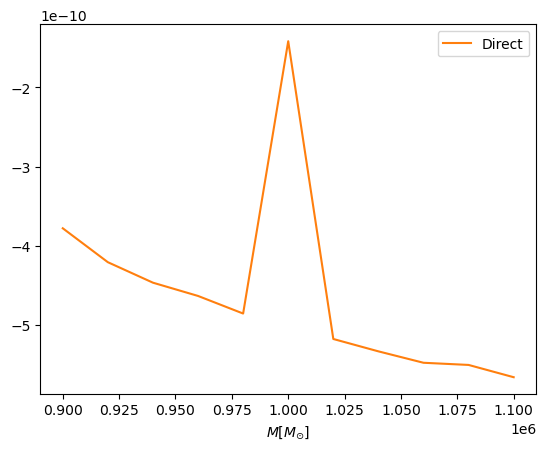

In [31]:
plt.plot(M_grid, direct_logL, color='C1', label='Direct')

plt.xlabel(r'$M [M_{\odot}]$')
plt.legend()
plt.show()

In [32]:
max_idx = np.argmax(direct_logL)
M_best = M_grid[max_idx]
logL_max = direct_logL[max_idx]

print(f"Best M: {M_best:.2e}")

Best M: 1.00e+06


The likelihood seems to be max for M=1e6, that is the correct value of the parameter. So this seems nice I guess.

Problem so far: 
- the computation of the pseudoinverse takes forever to be done.
- The initial log_prior was +/- infinite

### Try and vary mu

In [33]:
mu_grid = np.linspace(9.9, 10.1, 11)

direct_logL = -1 * np.ones(len(mu_grid))

# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
M=1e6
for idx, mu in tqdm(enumerate(mu_grid), total=len(mu_grid), desc='M grid'):
    emri_waveform_args_M = [
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    
    direct_logL[idx] = log_likelihood(chans, *emri_waveform_args_M)


M grid: 100%|██████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.10s/it]


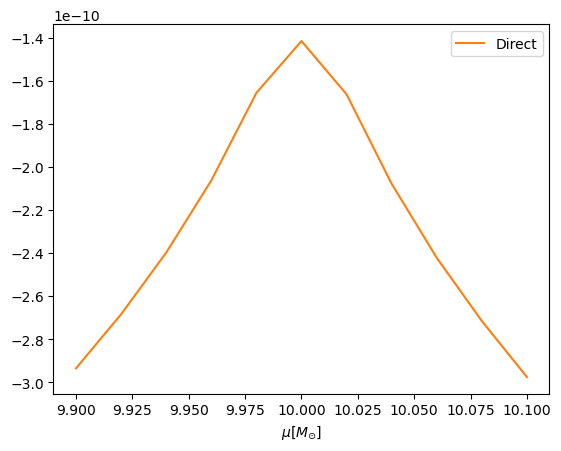

In [34]:
plt.plot(mu_grid, direct_logL, color='C1', label='Direct')

plt.xlabel(r'$\mu [M_{\odot}]$')
plt.legend()
plt.show()

In [35]:
max_idx = np.argmax(direct_logL)
mu_best = mu_grid[max_idx]
logL_max = direct_logL[max_idx]

print(f"Best mu: {mu_best:.2e}")

Best mu: 1.00e+01


I obtained a likelihood with the same behaviour as the Whittle likelihood (at least for these two parameters). 

# MCMC

In [36]:
def wrapper_likelihood(x, fixed_parameters, d=chans):
    # Only M and mu vary, others are fixed
    params = [x[0], x[1]] + fixed_parameters.tolist()
    return log_likelihood(d, *params)

In [37]:
priors = {'emri': ProbDistContainer({
    0: uniform_dist(9.999e5, 1.001e6),
    1: uniform_dist(9.99, 10.01)
}, return_gpu=use_gpu)}


fixed_parameters = np.array([
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
])

In [38]:
fname = "FD_gated_likelihood.h5"
if os.path.exists(fname):
    ts = datetime.datetime.now().strftime("_%Y%m%d_%H%M%S")
    os.rename(fname, fname.replace(".h5", ts + ".h5"))
backend = HDFBackend(fname)

In [39]:
# Initialize sampler with parallel pool
import multiprocessing 

NUM_CORES = max(multiprocessing.cpu_count() - 1, 1)

print(f"Starting MCMC with {NUM_CORES} processes")
multiprocessing.set_start_method('fork', force=True)
pool = multiprocessing.Pool(NUM_CORES)

sampler = EnsembleSampler(
    nwalkers=32,
    ndims={'emri': 2},
    log_like_fn=wrapper_likelihood,
    priors=priors,
    args=(fixed_parameters,),
    branch_names=['emri'],
    tempering_kwargs=dict(ntemps=10),
    pool=pool  # Enable parallel evaluation
)

# Starting positions
M=1e6
mu=10
injection = np.array([M, mu])
start = injection * (1 + 1e-7 * np.random.randn(10, 32, 1, 2))
start_state = State({'emri': start})

# Run MCMC
sampler.compute_log_prior(start_state.branches_coords)
sampler.run_mcmc(start_state, nsteps=500, progress=True)

print('MCMC completed')

chain = sampler.get_chain()
np.save('mcmc_chain_pure_signal.npy', chain)

Starting MCMC with 7 processes
eryn: Exception while calling your likelihood function:eryn: Exception while calling your likelihood function:eryn: Exception while calling your likelihood function:


eryn: Exception while calling your likelihood function:  args added:  args added:  args added: 
 eryn: Exception while calling your likelihood function: 
  args added:   args added:

KeyboardInterrupt: 

 eryn: Exception while calling your likelihood function:
eryn: Exception while calling your likelihood function:  args added:
  args added:  [array([9.99999956e+05, 1.00000010e+01])][array([9.99999877e+05, 1.00000007e+01])][array([9.99999964e+05, 1.00000006e+01])][array([1.00000002e+06, 1.00000013e+01])][array([1.00000010e+06, 1.00000011e+01])][array([1.00000022e+06, 9.99999997e+00])][array([9.99999959e+05, 9.99999919e+00])]






  args:  args:  args:  args:  args:  args:   args:     (array([0.5       , 5.2       , 0.5       , 1.        , 1.        ,
       0.52359878, 1.04719755, 0.52359878, 1.04719755, 1.04719755,
       0.52359878, 1.04719755]),) (array([0.5       , 5.2       , 0.5       , 1.        , 1.        ,
       0.52359878, 1.04719755, 0.52359878, 1.04719755, 1.04719755,
       0.52359878, 1.04719755]),)(array([0.5       , 5.2       , 0.5       , 1.        , 1.        ,
       0.52359878, 1.04719755, 0.52359878, 1.04719755, 1.04719755,
       0.52359878, 1.04719755]),)(arra

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/op

Backup